# **Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

# **Define Hyperparameters**

In [ ]:
num_epochs = 40
batch_size = 120
lr = 0.001

# **Obtaining the data set from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Processing**

Creating Class to Convert Dataset to be from image to Tensor format

In [ ]:
class ConvertData(Dataset):
  def __init__(self,array,transform = None):
    self.array = array
    self.transform = transform

  def __getitem__(self,index):
    image, label = self.array[index]
    if image.mode == 'RGBA':
      image = image.convert('RGB')  # Convert RGBA to RGB
    if self.transform:
      image = self.transform(image)
    return image, label

  def __len__(self):
    return len(self.array)

Creating an array of tuple of type pil image and label

In [ ]:
#0: white, 1: black, 2: asian, 3: indian, 4:others
datasets = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
race_labels = {i: {z:0 for z in range(17)} for i in range(5)}
min_label = 999
#Change key for different races
datadir = {0: '/content/drive/MyDrive/ECE324 Project/Data_Collection/Final Dataset/White Dataset',
           1: '/content/drive/MyDrive/ECE324 Project/Data_Collection/Final Dataset/Black Dataset',
           2: '/content/drive/MyDrive/ECE324 Project/Data_Collection/Final Dataset/Asian Dataset',
           3: '/content/drive/MyDrive/ECE324 Project/Data_Collection/Final Dataset/Indian Dataset',
           4: '/content/drive/MyDrive/ECE324 Project/Data_Collection/Final Dataset/Others'}
for race,link in datadir.items():
  for filename in os.listdir(link):
    filepath = os.path.join(link,filename)
    image = Image.open(filepath)
    #Reducing the filename to only the age
    try:
      filename = filename[filename.index('_') + 3 :]
      label = filename[: filename.index('.')]
      race_labels[race][int(label)] += 1
      min_label = min(int(label),min_label)
      datasets[race].append((image,int(label)))
    except:
      print("Error: " + str(filename))

#Reducing the race_labels' values to a 1/5 of its original values
for k,v in race_labels.items():
  for k1,v1, in race_labels[k].items():
    race_labels[k][k1] = int(v1/5)

Obtaining the Dataset that contains all the races by taking a 1/5 of each label from each dataset

In [ ]:
all_labels = {i : 0 for i in range(17)}
for k,v in datasets.items():
  for i in v:
    try:
      if race_labels[k][int(i[1])] > 0:
        datasets[5].append(i)
        all_labels[int(i[1])] += 1
        race_labels[k][int(i[1])] -= 1
    except:
      continue

Creating an age distribution diagram for the all races dataset & comparing the number of datapoints in the all races data set with every other races

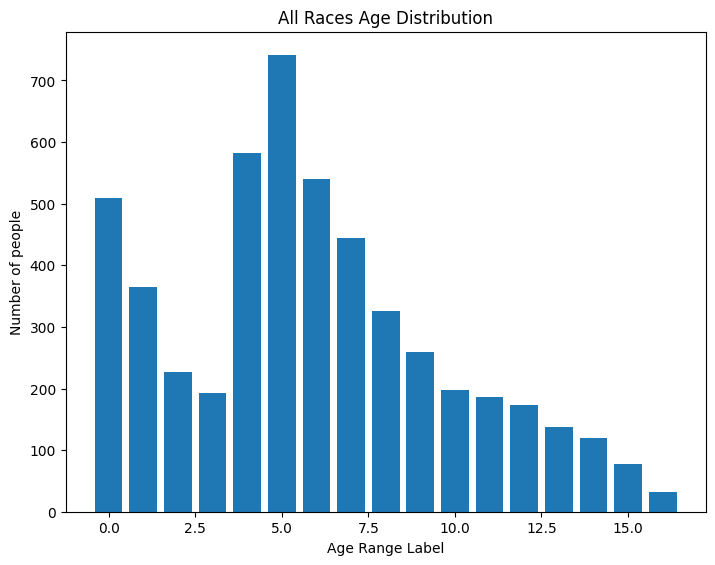

Total Datapoints for all races dataset: 5110




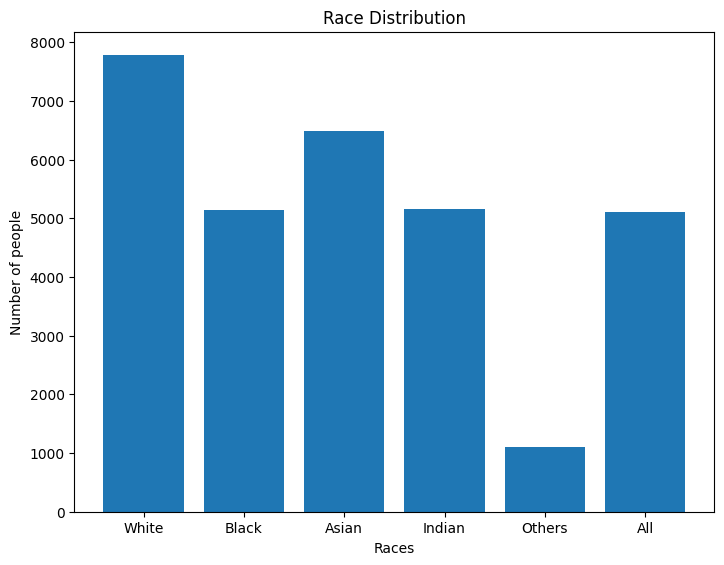

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
people = []
for k,v in all_labels.items():
  people.append(v)
ax.bar([i for i in range(17)], people)
ax.set_ylabel('Number of people')
ax.set_xlabel('Age Range Label')
ax.set_title('All Races Age Distribution')
plt.show()
print("Total Datapoints for all races dataset: " + str(sum(all_labels.values())))
print("\n")

fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
people = []
for k,v in datasets.items():
  people.append(len(v))
ax2.bar(['White','Black','Asian','Indian','Others', 'All'], people)
ax2.set_ylabel('Number of people')
ax2.set_xlabel('Races')
ax2.set_title('Race Distribution')
plt.show()

Calling the ConvertData class to convert to Tensor and Dataloader class

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
ImageSet_white  = ConvertData(datasets[0],transform = transform)
ImageSet_black  = ConvertData(datasets[1],transform = transform)
ImageSet_asian  = ConvertData(datasets[2], transform = transform)
ImageSet_indian = ConvertData(datasets[3], transform = transform)
ImageSet_others = ConvertData(datasets[4], transform = transform)
ImageSet_all    = ConvertData(datasets[5], transform = transform)


#Splitting the data into 80% Training, 10% Testing, and 10% Validation
#White training set
train_set_white, validation_set_white, test_set_white = torch.utils.data.random_split(ImageSet_white, [int(0.8 * len(datasets[0])), int(0.1 * len(datasets[0])), len(datasets[0]) - int(0.8 * len(datasets[0])) - int(0.1 * len(datasets[0]))])
train_loader_white = torch.utils.data.DataLoader(train_set_white, batch_size = batch_size, shuffle = True)
validation_loader_white = torch.utils.data.DataLoader(validation_set_white, batch_size = batch_size, shuffle = True)
test_loader_white = torch.utils.data.DataLoader(test_set_white,batch_size = batch_size, shuffle = True)

#Black training set
train_set_black, validation_set_black, test_set_black = torch.utils.data.random_split(ImageSet_black, [int(0.8 * len(datasets[1])), int(0.1 * len(datasets[1])), len(datasets[1]) - int(0.8 * len(datasets[1])) - int(0.1 * len(datasets[1]))])
train_loader_black = torch.utils.data.DataLoader(train_set_black, batch_size = batch_size, shuffle = True)
validation_loader_black = torch.utils.data.DataLoader(validation_set_black, batch_size = batch_size, shuffle = True)
test_loader_black = torch.utils.data.DataLoader(test_set_black ,batch_size = batch_size, shuffle = True)

#Asian training set
train_set_asian, validation_set_asian, test_set_asian = torch.utils.data.random_split(ImageSet_asian, [int(0.8 * len(datasets[2])), int(0.1 * len(datasets[2])), len(datasets[2]) - int(0.8 * len(datasets[2])) - int(0.1 * len(datasets[2]))])
train_loader_asian = torch.utils.data.DataLoader(train_set_asian, batch_size = batch_size, shuffle = True)
validation_loader_asian = torch.utils.data.DataLoader(validation_set_asian, batch_size = batch_size, shuffle = True)
test_loader_asian = torch.utils.data.DataLoader(test_set_asian ,batch_size = batch_size, shuffle = True)

#Indian training set
train_set_indian, validation_set_indian, test_set_indian = torch.utils.data.random_split(ImageSet_indian, [int(0.8 * len(datasets[3])), int(0.1 * len(datasets[3])), len(datasets[3]) - int(0.8 * len(datasets[3])) - int(0.1 * len(datasets[3]))])
train_loader_indian = torch.utils.data.DataLoader(train_set_indian, batch_size = batch_size, shuffle = True)
validation_loader_indian = torch.utils.data.DataLoader(validation_set_indian, batch_size = batch_size, shuffle = True)
test_loader_indian = torch.utils.data.DataLoader(test_set_indian ,batch_size = batch_size, shuffle = True)

#Others training set
train_set_others, validation_set_others, test_set_others = torch.utils.data.random_split(ImageSet_others, [int(0.8 * len(datasets[4])), int(0.1 * len(datasets[4])), len(datasets[4]) - int(0.8 * len(datasets[4])) - int(0.1 * len(datasets[4]))])
train_loader_others = torch.utils.data.DataLoader(train_set_others, batch_size = batch_size, shuffle = True)
validation_loader_others = torch.utils.data.DataLoader(validation_set_others, batch_size = batch_size, shuffle = True)
test_loader_others = torch.utils.data.DataLoader(test_set_others ,batch_size = batch_size, shuffle = True)

#All training set
train_set_all, validation_set_all, test_set_all = torch.utils.data.random_split(ImageSet_all, [int(0.8 * len(datasets[5])), int(0.1 * len(datasets[5])), len(datasets[5]) - int(0.8 * len(datasets[5])) - int(0.1 * len(datasets[5]))])
train_loader_all = torch.utils.data.DataLoader(train_set_all, batch_size = batch_size, shuffle = True)
validation_loader_all = torch.utils.data.DataLoader(validation_set_all, batch_size = batch_size, shuffle = True)
test_loader_all = torch.utils.data.DataLoader(test_set_all, batch_size = batch_size, shuffle = True)

data_learn = {0:[train_loader_white,validation_loader_white,test_loader_white], 1:[train_loader_black,validation_loader_black,test_loader_black],
              2: [train_loader_asian,validation_loader_asian,test_loader_asian], 3:[train_loader_indian,validation_loader_indian,test_loader_indian],
              4: [train_loader_others,validation_loader_others,test_loader_others], 5: [train_loader_all, validation_loader_all, test_loader_all]}

# **Convolutional Architecture**

Creating the Convolutional Class

Given an Image size of 3 x 32 x 32 for 3 rbg colour channels, the architecture of the CNN is as the following:

*   First convolutional Layer of input size 3, output size 6, and filter size of 3.
*   First Pooling Layer of size 2 by 2.
*   Second convolutional Layer of input size 6, output size of 16 and filter size 3.
*   Add a padding of 1 dimension
*   Second Pooling Layer of size 2 by 2.
*   Third convolutional Layer of input size 16, output size 24 and filter size of 3.
*   Add a padding of 1 dimension
*   Third Pooling Layer of size 2 by 2
*   First Fully Connected Layer of input size 24 * 3 * 3, and output size of 120.
*   Second Fully Connected Layer of input size 120, and output size of 84.
*   Third Fully Connected Layer of input size 84 and output size 36.
*   Fourth Fully Connected Layer of input size 36 and output size of 17 for the 17 classes.

Resulting Image from each Layer:
*   Before any convolutional layer, the image is of size 3 x 32 x 32.
*   After the first convolutional layer, the image is of size 6 x 30 x 30.
*   After the first Pooling layer, the image is reduced to 6 x 15 x 15.
*   After the second convolutional layer, the image is of size 16 x 13 x 13.
*   Add a padding layer to increase the size of the image to 6 x 14 x 14.
*   After the second Pooling layer, the image is reduced to size 16 x 7 x 7.
*   After the third convolutional layer, the image is of size 24 x 5 x 5
*   Add a padding layer to increase the size of the image to 24 x 6 x 6
*   After a third pooling layer, the image is reduced to size 24 x 3 x 3
*   Because of the size of the image after the third pooling layer, the input of the first fully connected layer is 24 x 3 x 3, and the output is size 120
*   The second and third fully connected layer then reduced the size to 84 then to 36.
*   The last fully connected layer then reduced to 17 for the 17 classes.



In [ ]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super(ConvolutionalNetwork, self).__init__()
    self.convlayer1 = nn.Conv2d(3, 6, 3)
    self.convlayer2 = nn.Conv2d(6,16,3)
    self.convlayer3 = nn.Conv2d(16,24, 3)
    self.pool = nn.MaxPool2d(2,2)
    self.FulCon1 = nn.Linear(24 * 3 * 3, 120)
    self.FulCon2 = nn.Linear(120,84)
    self.FulCon3 = nn.Linear(84,36)
    self.FulCon4 = nn.Linear(36,17)

    # Add padding layer before the last pooling layer
    self.padding = nn.ZeroPad2d((0, 1, 0, 1))

  def forward(self,x):
    #Activation function is relu
    x = self.pool(F.relu(self.convlayer1(x)))
    x = self.pool(self.padding(F.relu(self.convlayer2(x))))
    x = self.pool(self.padding(F.relu(self.convlayer3(x))))

    # Flatten it inorder to pass it into the fully connected layers
    x = x.view(-1, 24*3*3)
    x = F.relu(self.FulCon1(x))
    x = F.relu(self.FulCon2(x))
    x = F.relu(self.FulCon3(x))
    x = self.FulCon4(x)
    return x

Intializing the Model

In [ ]:
model0, model1, model2, model3, model4, model5 = ConvolutionalNetwork(),ConvolutionalNetwork(),ConvolutionalNetwork(),ConvolutionalNetwork(),ConvolutionalNetwork(), ConvolutionalNetwork()
models = {0: model0, 1: model1, 2: model2, 3: model3, 4: model4, 5: model5}
optimizer0, optimizer1, optimizer2, optimizer3, optimizer4, optimizer5 = torch.optim.AdamW(model0.parameters(), lr = lr),torch.optim.AdamW(model1.parameters(), lr = lr),torch.optim.AdamW(model2.parameters(), lr = lr),torch.optim.AdamW(model3.parameters(), lr = lr),torch.optim.AdamW(model4.parameters(), lr = lr), torch.optim.AdamW(model5.parameters(), lr = lr)
optimizers = {0: optimizer0, 1: optimizer1, 2: optimizer2, 3: optimizer3, 4: optimizer4, 5: optimizer5}
criterion = nn.CrossEntropyLoss()


# **Running the Algorithm**

In [ ]:
training_accuracies = {0: [], 1: [], 2: [], 3: [], 4: [], 5:[]}
epochs = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
valid_accuracies = {0: [], 1: [], 2: [], 3: [], 4: [], 5:[]}
training_loss = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
valid_loss = {0: [], 1: [], 2: [], 3: [], 4: [], 5:[]}
testing_acc = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
mse_plotting = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
mae_plotting = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
races = {0: 'Caucasian', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others', 5: 'All'}

for race, dataset in data_learn.items():
  total_steps = len(data_learn[race][0])
  increasing = 0
  validation_loss = 999
  print('\n')
  print("Training Model for race " + str(races[race]))
  for epoch in range(num_epochs):

    if increasing >= 5 and epoch > 20:
      print("Early Stopping")
      print("Stop at Epoch " + str(epoch))
      break

    training_acc = 0
    num_samples = 0

    #Training Loop for Training Set #train_loader
    for i, (images,labels) in enumerate(data_learn[race][0]):

      outputs = models[race](images)
      _,predicted = torch.max(outputs, 1)
      labels -= min_label
      loss = criterion(outputs, labels)

      optimizers[race].zero_grad()
      loss.backward()
      optimizers[race].step()
      training_acc += (predicted == labels).sum().item()
      num_samples += labels.size(0)

      #Plotting
      if (i + 1) % len(data_learn[race][0]) == 0:
        #Calculating mean square error
        e_sq = 0
        for i in range(len(predicted)):
          e_sq += (predicted[i] - labels[i]) ** 2
        mse = e_sq/len(predicted)
        e_abs = 0
        for i in range(len(predicted)):
          e_abs += abs(predicted[i] - labels[i])
        mae = e_abs/len(predicted)
        mse_plotting[race].append(mse.item())
        mae_plotting[race].append(mae.item())
        training_accuracies[race].append(100 * (training_acc/num_samples))
        training_loss[race].append(loss.item())
        epochs[race].append(epoch)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}')
        print("Training Accuracy: " + str(100 * (training_acc / num_samples)))
        print("Training Loss: " + str(loss.item()))
        print("Mean Square Error: " + str(mse.item()))
        print("Mean Absolute Error: " + str(mae.item()))


    #Loop for Validation Set
    valid_acc = 0
    num_samples = 0
    for i, (images, labels) in enumerate(data_learn[race][1]):

      outputs = models[race](images)
      _,predicted = torch.max(outputs, 1)
      labels -= min_label
      loss = criterion(outputs,labels)
      loss.backward()
      valid_acc += (predicted == labels).sum().item()
      num_samples += labels.size(0)

      #Plotting
      if (i + 1) % len(data_learn[race][1]) == 0:
        valid_accuracies[race].append(100 * (valid_acc/ num_samples))
        valid_loss[race].append(loss.item())
        if loss.item() < validation_loss:
          increasing = 0
        elif loss.item() > validation_loss:
          increasing += 1
        validation_loss = loss.item()
        print("Validation Accuracy :" + str(100 * (valid_acc / num_samples)))
        print("Validation Loss: " + str(loss.item()))
        print("")

  print('Training Complete')

  with torch.no_grad():
    age_loss = 0
    correct = 0
    total_samples = 0
    for images, labels in data_learn[race][2]:

      outputs = models[race](images)
      _, predicted = torch.max(outputs, 1)
      total_samples += labels.size(0)
      for i in range(len(predicted)):
        if (predicted[i] + min_label) == labels[i]:
          correct += 1
        age_loss += abs((predicted[i] + min_label) - labels[i])
    acc = 100 * correct / total_samples
    testing_acc[race].append(acc)
    avg_age_loss = age_loss/total_samples
    print("Testing Accuracy for race " + str(races[race]) + ": " + str(acc))
    print("Average Difference between predicted age and actual age per data point is " + str(avg_age_loss.item()))

all_model_testing_acc = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
for race,dataset in data_learn.items():
  with torch.no_grad():
    correct = 0
    total_samples = 0
    for images, labels in data_learn[race][2]:
      outputs = models[5](images)
      _, predicted = torch.max(outputs, 1)
      total_samples += labels.size(0)
      for i in range(len(predicted)):
        if (predicted[i] + min_label) == labels[i]:
          correct += 1
    acc = 100 * correct / total_samples
    all_model_testing_acc[race].append(acc)
    print("Testing Accuracy for race " + str(races[race]) + " predicted by all races model: " + str(acc))



Training Model for race Caucasian
Epoch [1/40], Step [112/52], Loss: 2.6805
Training Accuracy: 10.413992297817714
Training Loss: 2.6805155277252197
Mean Square Error: 19.785715103149414
Mean Absolute Error: 3.517857074737549
Validation Accuracy :13.478818998716303
Validation Loss: 2.6924500465393066

Epoch [2/40], Step [112/52], Loss: 2.5510
Training Accuracy: 11.521181001283697
Training Loss: 2.551044464111328
Mean Square Error: 24.098215103149414
Mean Absolute Error: 3.7589285373687744
Validation Accuracy :11.681643132220795
Validation Loss: 2.489821434020996

Epoch [3/40], Step [112/52], Loss: 2.5319
Training Accuracy: 17.089216944801027
Training Loss: 2.5318799018859863
Mean Square Error: 59.36606979370117
Mean Absolute Error: 5.6875
Validation Accuracy :19.897304236200256
Validation Loss: 2.4338510036468506

Epoch [4/40], Step [112/52], Loss: 2.3038
Training Accuracy: 19.961489088575096
Training Loss: 2.303786516189575
Mean Square Error: 30.866071701049805
Mean Absolute Error: 3

# **Data Analysis**

**General Plotting Comparing Between Different Races**

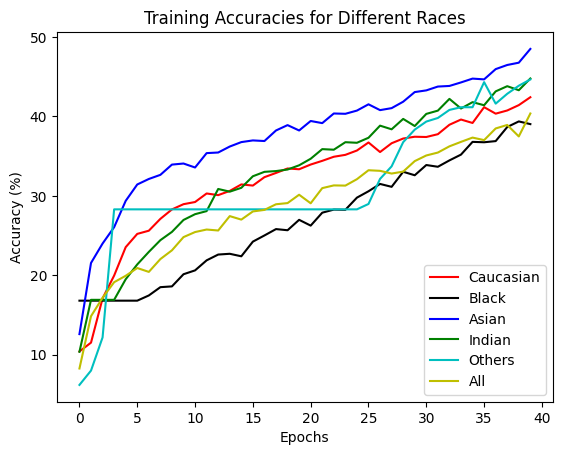

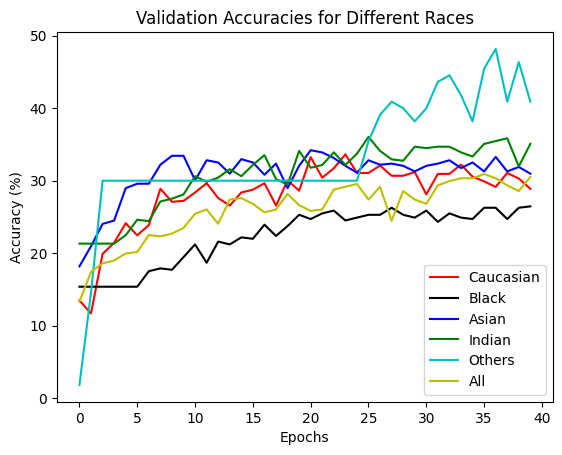

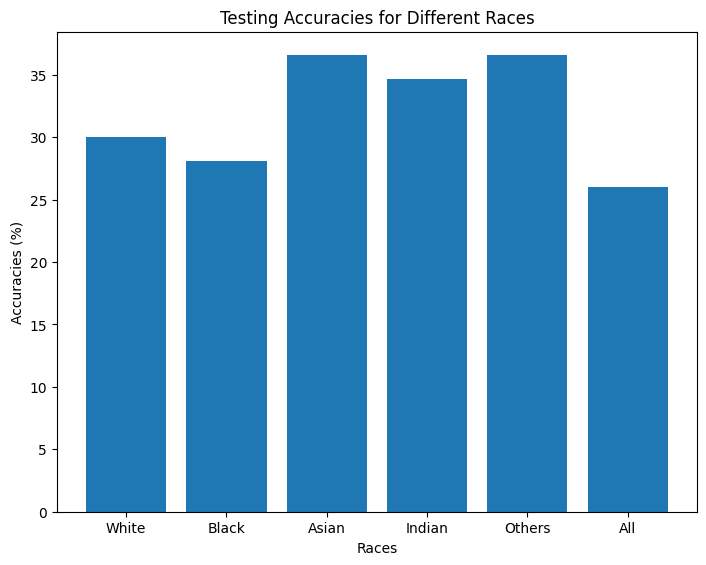

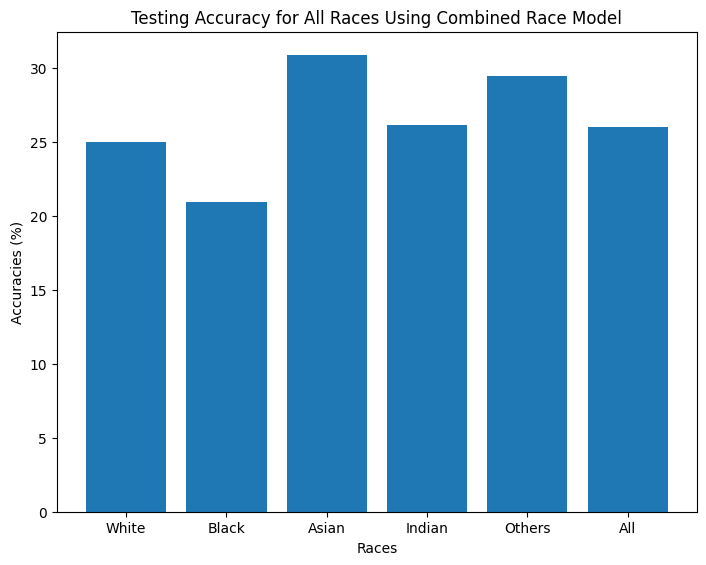

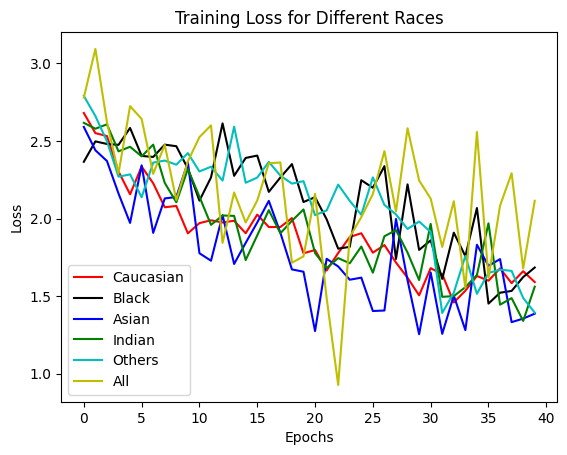

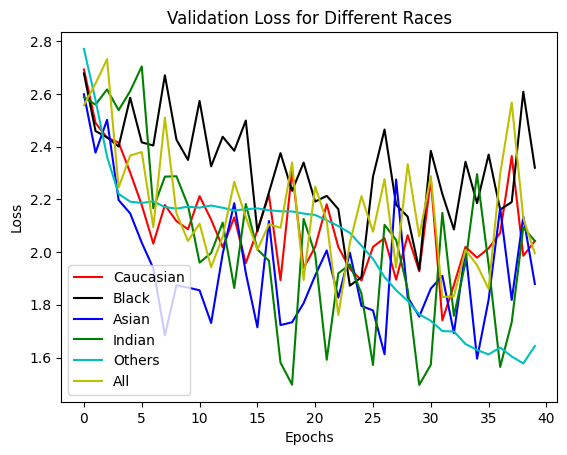

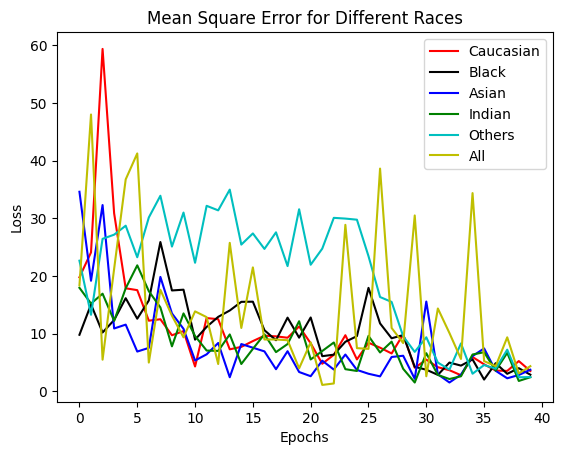

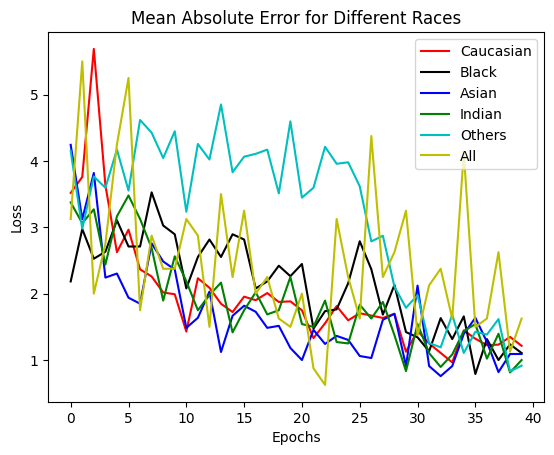

In [ ]:
#Training Accuracies
plt.plot(epochs[0], training_accuracies[0], color = 'r', label = 'Caucasian')
plt.plot(epochs[1], training_accuracies[1], color = 'k', label = 'Black')
plt.plot(epochs[2], training_accuracies[2], color = 'b', label = 'Asian')
plt.plot(epochs[3], training_accuracies[3], color = 'g', label = 'Indian')
plt.plot(epochs[4], training_accuracies[4], color = 'c', label = 'Others')
plt.plot(epochs[5], training_accuracies[5], color = 'y', label = 'All')
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.title("Training Accuracies for Different Races")
plt.legend()
plt.show()

print("\n")

#Validation Accuracies
plt.plot(epochs[0], valid_accuracies[0], color = 'r', label = 'Caucasian')
plt.plot(epochs[1], valid_accuracies[1], color = 'k', label = 'Black')
plt.plot(epochs[2], valid_accuracies[2], color = 'b', label = 'Asian')
plt.plot(epochs[3], valid_accuracies[3], color = 'g', label = 'Indian')
plt.plot(epochs[4], valid_accuracies[4], color = 'c', label = 'Others')
plt.plot(epochs[5], valid_accuracies[5], color = 'y', label = 'All')
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.title("Validation Accuracies for Different Races")
plt.legend()
plt.show()

print("\n")

#Testing Accuracies
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = []
races_class_plot = ['White','Black','Asian','Indian','Others','All']
for k,v in testing_acc.items():
  acc.append(v[0])
ax.bar(races_class_plot, acc)
ax.set_ylabel('Accuracies (%)')
ax.set_xlabel('Races')
ax.set_title('Testing Accuracies for Different Races')
plt.show()
print('\n')

#All Model Testing Accuracies on all Races
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
acc = []
for k,v in all_model_testing_acc.items():
  acc.append(v[0])
ax2.bar(races_class_plot,acc)
ax2.set_ylabel('Accuracies (%)')
ax2.set_xlabel('Races')
ax2.set_title('Testing Accuracy for All Races Using Combined Race Model')
plt.show()
print('\n')

#Training Loss
plt.plot(epochs[0], training_loss[0], color = 'r', label = 'Caucasian')
plt.plot(epochs[1], training_loss[1], color = 'k', label = 'Black')
plt.plot(epochs[2], training_loss[2], color = 'b', label = 'Asian')
plt.plot(epochs[3], training_loss[3], color = 'g', label = 'Indian')
plt.plot(epochs[4], training_loss[4], color = 'c', label = 'Others')
plt.plot(epochs[5], training_loss[5], color = 'y', label = 'All')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training Loss for Different Races")
plt.legend()
plt.show()

print("\n")

#Validation Loss
plt.plot(epochs[0], valid_loss[0], color = 'r', label = 'Caucasian')
plt.plot(epochs[1], valid_loss[1], color = 'k', label = 'Black')
plt.plot(epochs[2], valid_loss[2], color = 'b', label = 'Asian')
plt.plot(epochs[3], valid_loss[3], color = 'g', label = 'Indian')
plt.plot(epochs[4], valid_loss[4], color = 'c', label = 'Others')
plt.plot(epochs[5], valid_loss[5], color = 'y', label = 'All')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Validation Loss for Different Races")
plt.legend()
plt.show()

print("\n")

#MSE
plt.plot(epochs[0], mse_plotting[0], color = 'r', label = 'Caucasian')
plt.plot(epochs[1], mse_plotting[1], color = 'k', label = 'Black')
plt.plot(epochs[2], mse_plotting[2], color = 'b', label = 'Asian')
plt.plot(epochs[3], mse_plotting[3], color = 'g', label = 'Indian')
plt.plot(epochs[4], mse_plotting[4], color = 'c', label = 'Others')
plt.plot(epochs[5], mse_plotting[5], color = 'y', label = 'All')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Mean Square Error for Different Races")
plt.legend()
plt.show()

print("\n")

#MAE
plt.plot(epochs[0], mae_plotting[0], color = 'r', label = 'Caucasian')
plt.plot(epochs[1], mae_plotting[1], color = 'k', label = 'Black')
plt.plot(epochs[2], mae_plotting[2], color = 'b', label = 'Asian')
plt.plot(epochs[3], mae_plotting[3], color = 'g', label = 'Indian')
plt.plot(epochs[4], mae_plotting[4], color = 'c', label = 'Others')
plt.plot(epochs[5], mae_plotting[5], color = 'y', label = 'All')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Mean Absolute Error for Different Races")
plt.legend()
plt.show()


**Plotting for Caucasian Race**

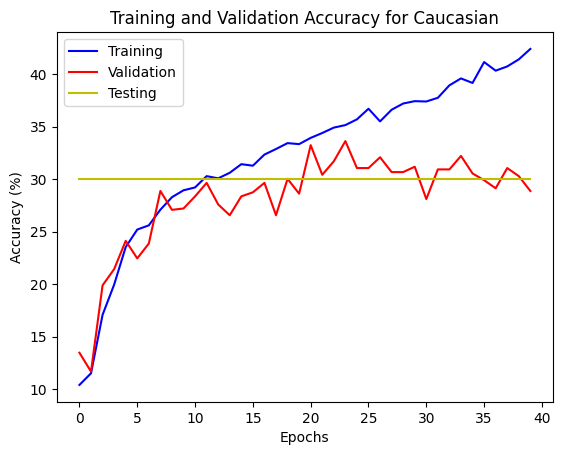

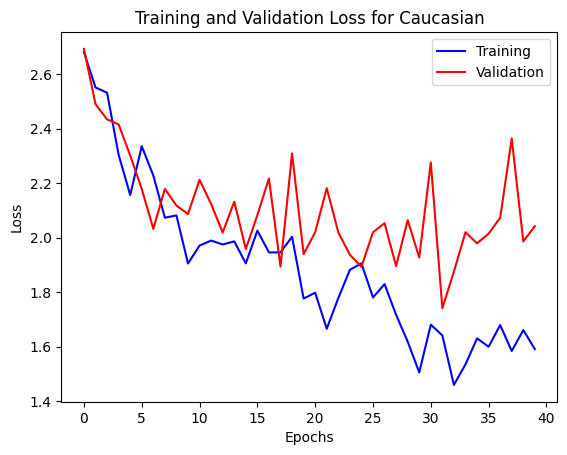

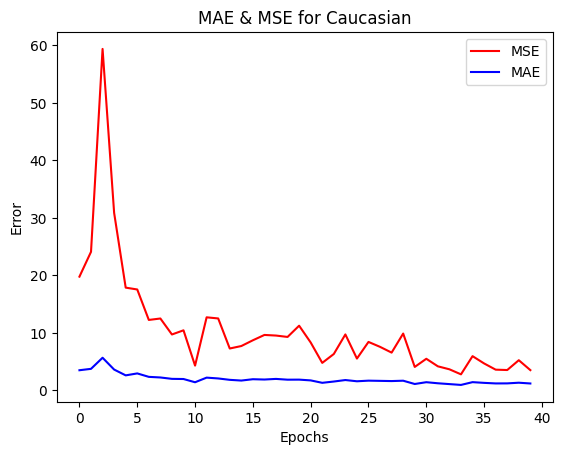

In [ ]:
plt.plot(epochs[0], training_accuracies[0], color = 'b', label = 'Training')
plt.plot(epochs[0],valid_accuracies[0], color = 'r', label = 'Validation')
plt.plot(epochs[0], testing_acc[0] * len(training_accuracies[0]), color = 'y', label = 'Testing')
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.title("Training and Validation Accuracy for Caucasian")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[0], training_loss[0], color = 'b', label = 'Training')
plt.plot(epochs[0], valid_loss[0], color = 'r', label = 'Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Validation Loss for Caucasian")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[0], mse_plotting[0], color = 'r', label = 'MSE')
plt.plot(epochs[0], mae_plotting[0], color = 'b', label = 'MAE')
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.title("MAE & MSE for Caucasian")
plt.legend()
plt.show()

**Plotting for Black Race**

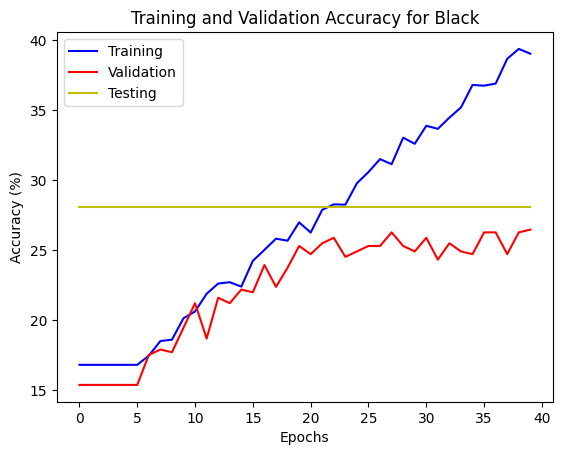

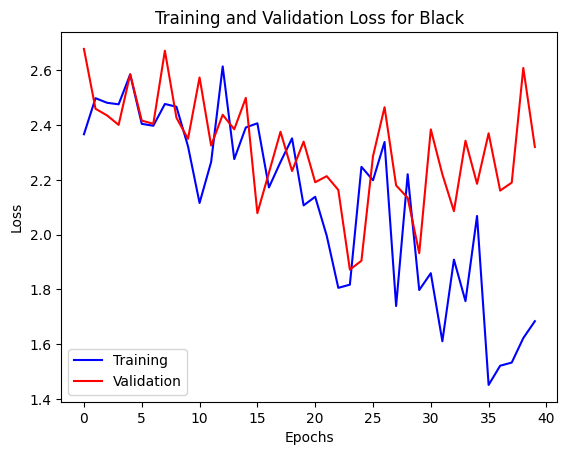

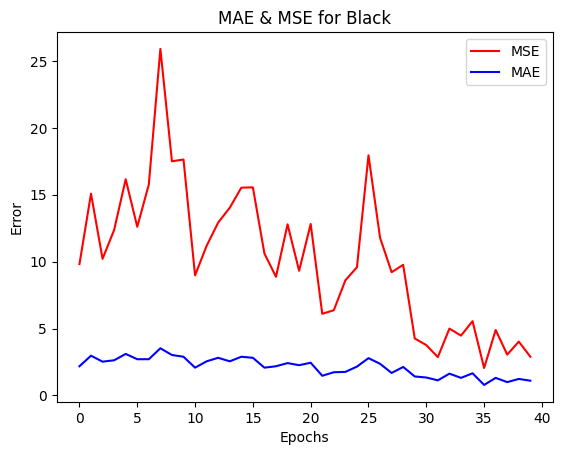

In [ ]:
plt.plot(epochs[1], training_accuracies[1], color = 'b', label = 'Training')
plt.plot(epochs[1],valid_accuracies[1], color = 'r', label = 'Validation')
plt.plot(epochs[1], testing_acc[1] * len(training_accuracies[1]), color = 'y', label = 'Testing')
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.title("Training and Validation Accuracy for Black")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[1], training_loss[1], color = 'b', label = 'Training')
plt.plot(epochs[1], valid_loss[1], color = 'r', label = 'Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Validation Loss for Black")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[1], mse_plotting[1], color = 'r', label = 'MSE')
plt.plot(epochs[1], mae_plotting[1], color = 'b', label = 'MAE')
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.title("MAE & MSE for Black")
plt.legend()
plt.show()

**Plotting for Asian Race**

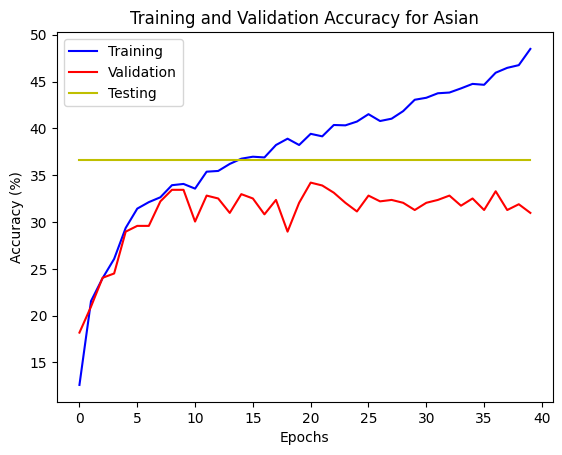

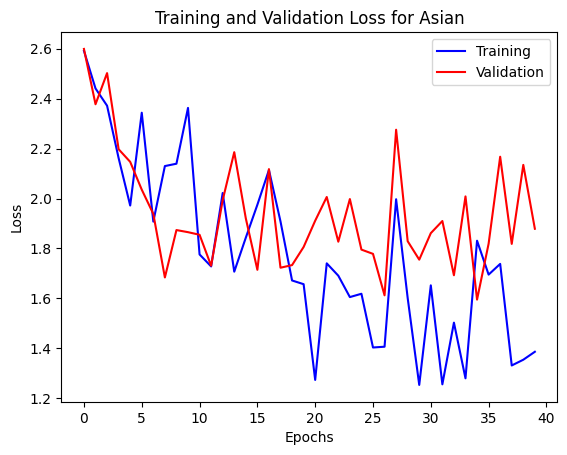

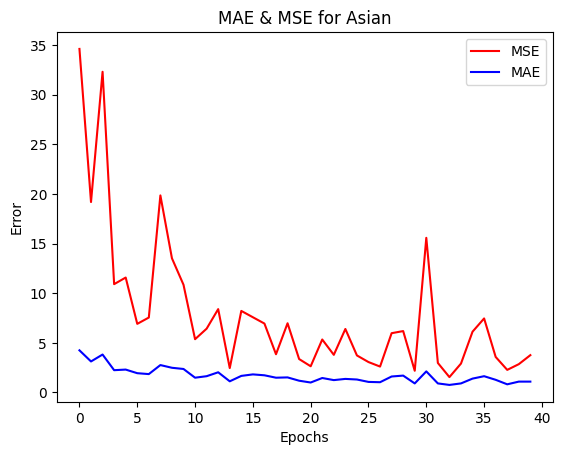

In [ ]:
plt.plot(epochs[2], training_accuracies[2], color = 'b', label = 'Training')
plt.plot(epochs[2],valid_accuracies[2], color = 'r', label = 'Validation')
plt.plot(epochs[2], testing_acc[2] * len(training_accuracies[2]), color = 'y', label = 'Testing')
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.title("Training and Validation Accuracy for Asian")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[2], training_loss[2], color = 'b', label = 'Training')
plt.plot(epochs[2], valid_loss[2], color = 'r', label = 'Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Validation Loss for Asian")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[2], mse_plotting[2], color = 'r', label = 'MSE')
plt.plot(epochs[2], mae_plotting[2], color = 'b', label = 'MAE')
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.title("MAE & MSE for Asian")
plt.legend()
plt.show()

**Plotting for Indian Race**

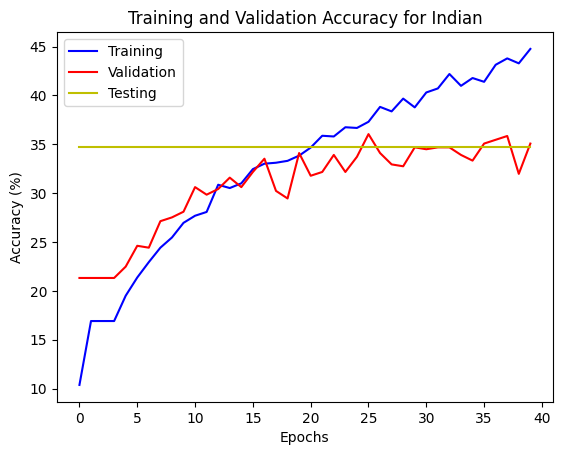

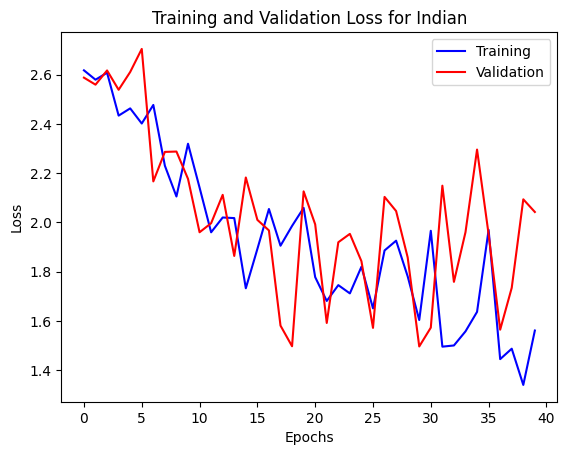

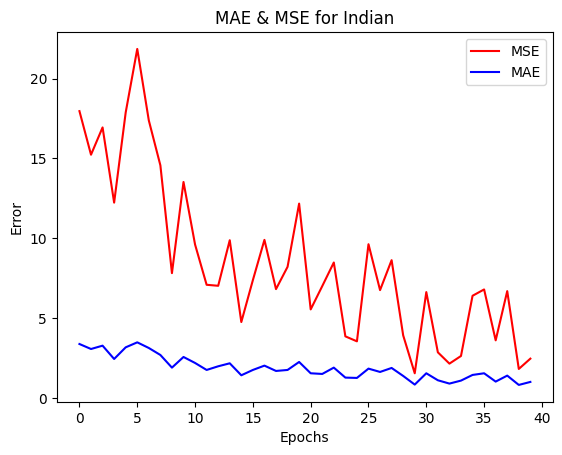

In [ ]:
plt.plot(epochs[3], training_accuracies[3], color = 'b', label = 'Training')
plt.plot(epochs[3],valid_accuracies[3], color = 'r', label = 'Validation')
plt.plot(epochs[3], testing_acc[3] * len(training_accuracies[3]), color = 'y', label = 'Testing')
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.title("Training and Validation Accuracy for Indian")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[3], training_loss[3], color = 'b', label = 'Training')
plt.plot(epochs[3], valid_loss[3], color = 'r', label = 'Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Validation Loss for Indian")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[3], mse_plotting[3], color = 'r', label = 'MSE')
plt.plot(epochs[3], mae_plotting[3], color = 'b', label = 'MAE')
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.title("MAE & MSE for Indian")
plt.legend()
plt.show()

**Plotting for Other Races**

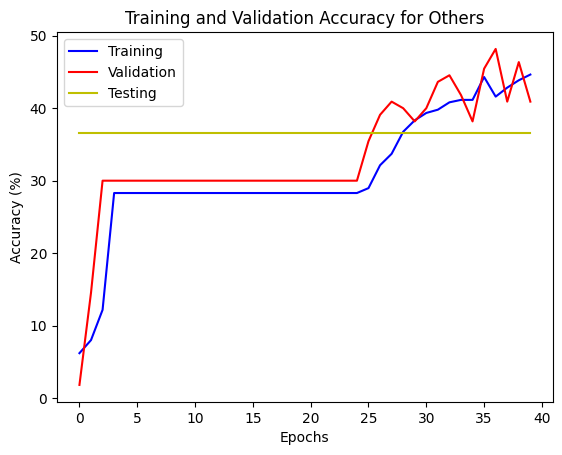

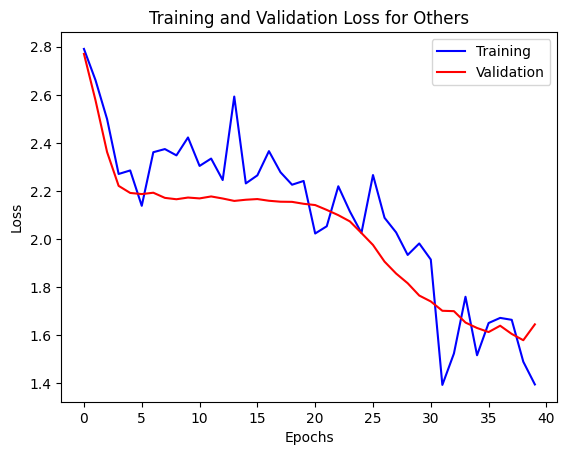

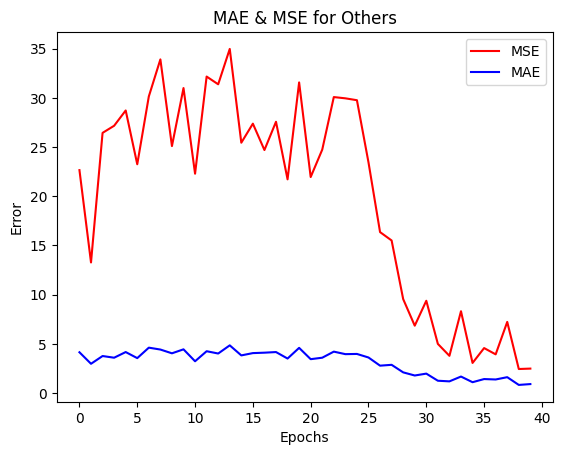

In [ ]:
plt.plot(epochs[4], training_accuracies[4], color = 'b', label = 'Training')
plt.plot(epochs[4],valid_accuracies[4], color = 'r', label = 'Validation')
plt.plot(epochs[4], testing_acc[4] * len(training_accuracies[4]), color = 'y', label = 'Testing')
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.title("Training and Validation Accuracy for Others")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[4], training_loss[4], color = 'b', label = 'Training')
plt.plot(epochs[4], valid_loss[4], color = 'r', label = 'Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Validation Loss for Others")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[4], mse_plotting[4], color = 'r', label = 'MSE')
plt.plot(epochs[4], mae_plotting[4], color = 'b', label = 'MAE')
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.title("MAE & MSE for Others")
plt.legend()
plt.show()

**Plotting for All Races**

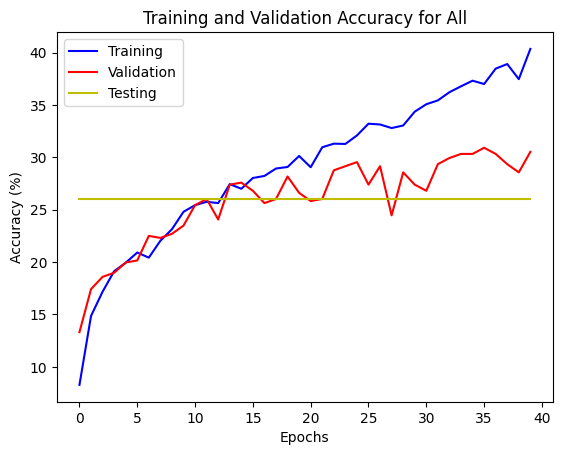

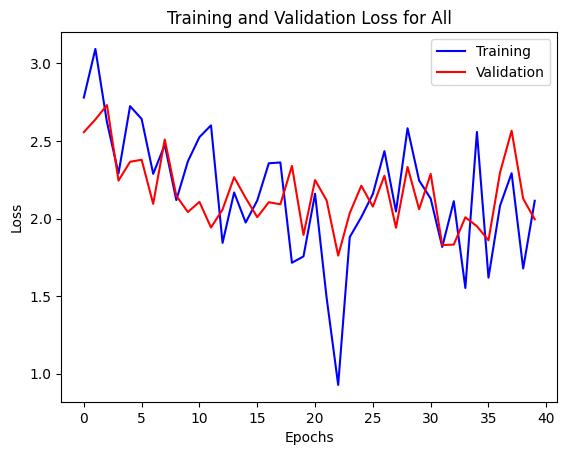

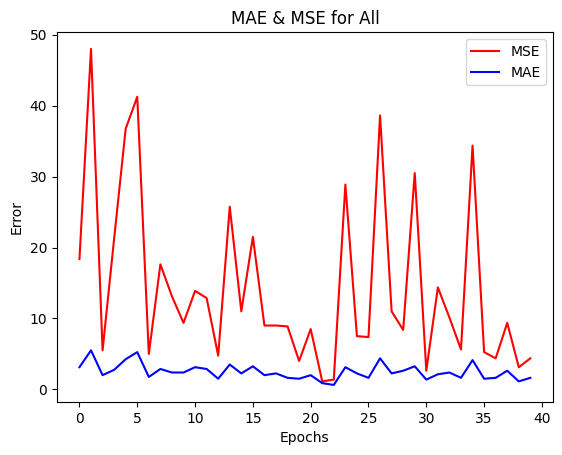

In [ ]:
plt.plot(epochs[5], training_accuracies[5], color = 'b', label = 'Training')
plt.plot(epochs[5],valid_accuracies[5], color = 'r', label = 'Validation')
plt.plot(epochs[5], testing_acc[5] * len(training_accuracies[5]), color = 'y', label = 'Testing')
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.title("Training and Validation Accuracy for All")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[5], training_loss[5], color = 'b', label = 'Training')
plt.plot(epochs[5], valid_loss[5], color = 'r', label = 'Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Validation Loss for All")
plt.legend()
plt.show()
print('\n')

plt.plot(epochs[5], mse_plotting[5], color = 'r', label = 'MSE')
plt.plot(epochs[5], mae_plotting[5], color = 'b', label = 'MAE')
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.title("MAE & MSE for All")
plt.legend()
plt.show()